In [114]:
import numpy as np
import matplotlib.pyplot as plt
from FD_Vlasov_supp import *
import importlib
importlib.import_module('mpl_toolkits.mplot3d').__path__
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import numpy.linalg as la

% matplotlib inline
np.set_printoptions(precision = 2)

Solve Vlasov's equation in one space dimension and one velocity dimension:
\begin{equation}
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} + E(t,x)\frac{\partial f}{\partial v} = 0
\end{equation}
With $x \in (0,L)$ and $v \in (-\infty, \infty)$, and $\lim_{|v|\to \infty} f(t,x,v) = 0$

We also need boundary conditions for the spatial dimension... which I'm not too sure about.  I'll try homogenous neumann for $x$ (closed domain)

We'll use a cutoff velocity $L_v$ to define our computational domain for $v$.  The electric field can be solved through:
\begin{align}
-\frac{\partial^2 \Phi}{\partial x^2}(t,x) &= \frac{q}{\epsilon_0}\int_{\mathbb{R}}f(t,x,v)dv\\
E(t,x) &= -\frac{\partial \Phi}{\partial x}
\end{align}
Again, I'm not too sure about boundary conditions for the potential...I'll say the potential is zero at the walls but this is iffy

Initial Condition here

We'll discretize in space and velocity first.  This is a scalar conservation law:
\begin{equation}
\frac{\partial f}{\partial t} + \nabla \cdot \mathbf{F}(f) = 0
\end{equation}
where 
\begin{equation}
\mathbf{F}(f) = \begin{pmatrix}
vf\\
E(t,x)f \end{pmatrix}
\end{equation}
Couple of things to try here:

First, extend the 1d Lax-Friedrich's method dimension by dimension:
\begin{align}
f_{i,j}^{n+1} = &\frac{1}{2}(f_{i+1,j}^n + f_{i-1,j}^n + f_{i,j+1}^n + f_{i,j-1}) - f_{i,j}^n \\
& - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_{i-1,j}^n) - E(t_n,x_i)\frac{\Delta t}{2 \Delta v}(f_{i,j+1}^n - f_{i,j-1}^n)
\end{align}
This looks a tad weird so alternatively, one could try:
\begin{align}
f_{i,j}^{n+1} = &\frac{1}{4}(f_{i+1,j}^n + f_{i-1,j}^n + f_{i,j+1}^n + f_{i,j-1}) \\
& - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_{i-1,j}^n) - E(t_n,x_i)\frac{\Delta t}{2 \Delta v}(f_{i,j+1}^n - f_{i,j-1}^n)
\end{align}

Finally, we could try dimensional splitting:
\begin{equation}
f_{i,j}^* = \frac{1}{2}(f_{i+1,j}^n + f_{i-1,j}^n) - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_{i-1,j}^n)
\end{equation}
first solving a 1d advection problem in $x$-direction (with smaller timestep) and then
\begin{equation}
f_{i,j}^n = \frac{1}{2}(f_{i,j+1}^* + f_{i,j-1}^*) - E(t_n,x_i)\frac{\Delta t}{2\Delta v}(f_{i,j+1}^* - f_{i,j-1}^*)
\end{equation}
an advection in the velocity direction

In [156]:
Lv = 20     # approximation to "infinity" for velocity space

k = 0.483
L = 2*np.pi/k  # length of spatial domain, which is periodic


nx = 100
nv = 200   # 

x = np.linspace(0,L,nx)
v = np.linspace(-Lv,Lv,nv)
dx = x[1] - x[0]
dv = v[1] - v[0]

X,V = np.meshgrid(x,v)  # represent as grid

def initial_u(x,v):
    z = np.exp(-(v**2)/2)
    z = z/(np.sqrt(2*np.pi)*L)
    return z

U = np.zeros((nv+2,nx+2)) # computational domain plus ghost points
 
U[1:-1,1:-1] = initial_u(X,V)

In [154]:
X.shape

(200, 100)

In [135]:
def space_derivative(u,dx,nv):

    mid = int(np.floor(nv/2))
    upper_U = u[:mid,:]
    lower_U = u[mid:,:]
    dudx = np.zeros_like(u)
    
    dudx[:mid,:] = np.roll(upper_U,-1,axis = 1) - upper_U
    dudx[mid:,:] = lower_U - np.roll(lower_U,1,axis = 1)
    dudx = dudx/dx
    
    # homogeneous neumann
    dudx[:,0] = 0
    dudx[:,-1] = 0
    
    return dudx[1:-1,:] # don't need to update Dirichlet B.C's

def velocity_derivative(u,dv,E): #upwinding???
    # will need to look at sign of E
    # E will be a 1D vector
    E_pos = np.where(E >= 0)
    E_neg = np.where(E < 0)
    
    dudv = np.zeros_like(u)
    dudv[:,E_pos] = dudv[:,E_pos] - np.roll(u,1,axis = 0)[:,E_pos]
    dudv[:,E_neg] = np.roll(u,-1,axis = 0)[:,E_neg] - dudv[:,E_neg]
    
    dudv = dudv/dv
    
    return dudv[1:-1,:]

def Forward_Euler_step(U,dt,E,V,dudx,dudv):
    Unew = U
    dudx = space_derivative(U,dx,)
    Unew[1:-1,:] = U[1:-1,:] + dt*(-V*dudx - E*dudv)
    return Unew

def integrate_u(u):
    int_u = np.zeros(nx,)
    
    # assume u has no redundant column
    int_u = integrate.simps(u,v,axis = 0)
    
    return int_u

In [136]:
# temporary! solve for E(t,x) by centered finite differences
def solve_bvp(U):
    A = np.diag(2*np.ones(nx-2,)) - np.diag(np.ones(nx-3,),-1) - np.diag(np.ones(nx-3,),1)
    A = A/((x[1] - x[0])**2)   # assumes evenly spaced x
    rho = integrate_u(U)
    phi = np.zeros(nx,)
    phi[1:-1] = la.solve(A,rho[1:-1])
    return phi

def compute_electric_field(U):
    dx = x[1] - x[0]
    phi = solve_bvp(U)
    E = -np.gradient(phi,dx,edge_order = 2)
    E = E.reshape(1,-1)
    E = np.repeat(E,nv,axis = 0)
    return 0*E + 1

In [150]:
# first step
steps = 20
dt = 1/50
for i in range(steps):
    E = compute_electric_field(U)
    dudx = space_derivative(U,dx,nv)
    dudv = velocity_derivative(U,dv,E[1,:])
    U[1:-1,:] = U[1:-1,:] + dt*(-v*dudx - E[1:-1,:]*dudv)

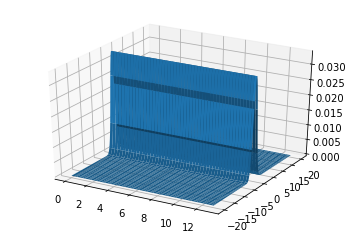

In [145]:
fig = plt.figure(1)
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(X,V,U,antialiased = True,linewidth = 0)

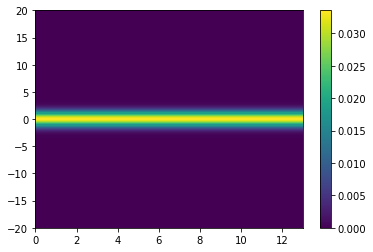

In [146]:
plt.pcolor(X,V,U)
plt.colorbar()

In [151]:
integrate_u(U)*L

array([ 18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
        18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,  18.93,
      

In [172]:
2*(x[1] - x[0])**2

0.14096240826730755